This is very much based on `sugar_snapshot_prep` and `Getting_kT_of_regions` but just done in a smoother way and with a single purpose in mind

In [1]:
import os
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

['/data2/GLUT5_string/string/analysis/scripts', '/home/semccomas/anaconda3/envs/string_method/lib/python38.zip', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/lib-dynload', '', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages', '../../string-method-gmxapi/', '../../string-method-gmxapi/stringmethod/simulations/../../']


In [2]:
MSM_sim_dir = "../../string_sims/TMD_initial_path/influx_BFRU_gate_CV"

F = np.load(f'{MSM_sim_dir}/F_MSM.npy')
extent = np.load(f'{MSM_sim_dir}/extent_MSM.npy')
cv_proj = np.load(f'{MSM_sim_dir}/cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

This just makes viz easier

In [3]:
def get_G5_atomistic_gate(timestep):
    # get all pieces together, then colors and naming consistent in plots
    G5_Out = np.array(['OUT', 'Out Open', 'green', "Greens"])
    G5_OutOcc = np.array(['OUT-OCC', 'Out Occ.', 'grey', "Greys"])
    G5_Occ = np.array(['OCC', 'Occluded', 'red', "Reds"])
    G5_InOcc = np.array(['IN-OCC', 'In Occ.', 'orange', "Oranges"])
    G5_In = np.array(['IN', 'In Open', 'blue', "Blues"])
    all_sims = np.array([G5_Out, G5_OutOcc, G5_Occ, G5_InOcc, G5_In])

    indir = '/data2/GLUT5_string/string/analysis/textfiles_out/EC_IC_gate_refs'

 
    out_arr = []
    for n, sim in enumerate(all_sims):
        name = sim[0]
        ec = np.loadtxt(f"{indir}/{name}.EC.{timestep}.xvg")[1]
        ic = np.loadtxt(f"{indir}/{name}.IC.{timestep}.xvg")[1]
        
        
        temp = np.append(all_sims[n], [f'EC: {str(ec)}', f'IC: {str(ic)}'])
        out_arr.append(temp)

    out_arr = np.array(out_arr)
    return out_arr

In [4]:
plot_atomistic = True
name = 'start_model'
#name = 'end_atom'
atom_sims = get_G5_atomistic_gate(name)

Here we create a dictionary which will loop through your `IC` and `EC` values from `extent` to then assign IC and EC spaces to each grid name. This is how we got the grid names in the first place

In [5]:
IC_extent = np.linspace(extent[0], extent[1], 55)
EC_extent = np.linspace(extent[2], extent[3], 55)

grid_label=0
grid_label_coord_dict = {}

for y_grid_index in range(0, 55):
    for x_grid_index in range(0, 55):
        if x_grid_index < 54 and y_grid_index < 54:
            IC_leftmost = IC_extent[x_grid_index] - 0.01
            IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
            EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
            EC_lowermost = EC_extent[y_grid_index] - 0.01

            coords = [IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost]    
            grid_label_coord_dict[grid_label] = coords
            grid_label = grid_label + 1

## Other functions

In [6]:
def plot_FES(fig,ax,vmax=10):
    ax.contourf(F, extent=extent,cmap='magma_r', levels=[0,1,2,3,4,5,6,7,8,9,10],vmin=0,vmax=vmax)
    ax.contour(F, extent=extent,colors='black', linewidths=0.4, levels=[0,1,2,3,4,5,6,7,8,9,10],vmin=0,vmax=vmax)
    
    ax.set_xlabel(cv_labels[0])
    ax.set_ylabel(cv_labels[1])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

# Step 1 - choose your CV space

I enable `widget` here so that you can easily zoom in and select regions from the FES. The blue dots plotted on top are to show where the "F" is being calculated for each histogram grid, so you can easily select for a specific grid if you want to

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
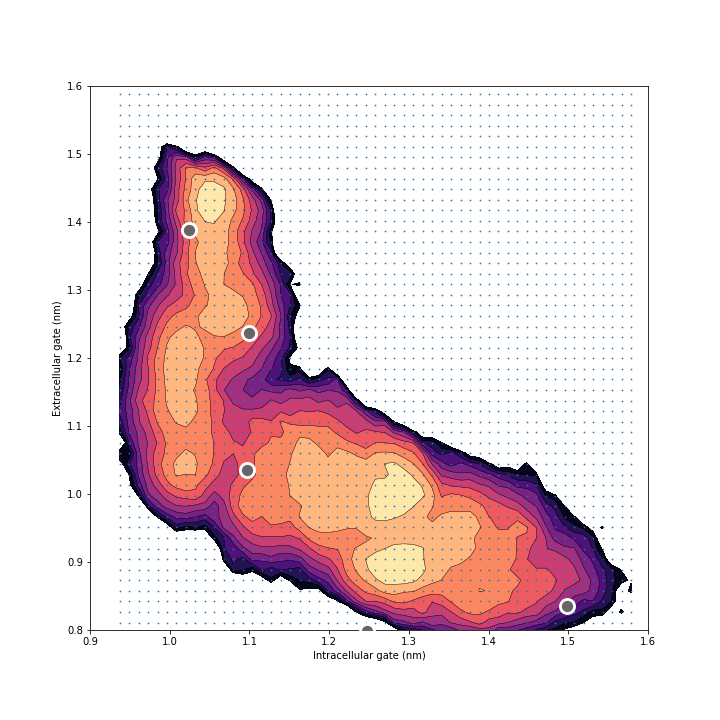

In [23]:
%matplotlib widget

f,ax=plt.subplots(1,1,figsize=(10,10))

plot_FES(f,ax)


markers = ['o','o','o','o','o']
sizes = [200,200,200,200,200]
if plot_atomistic:
    for n, sim in enumerate(atom_sims):
        ic = float(sim[-1].split(' ')[1])
        ec = float(sim[-2].split(' ')[1])
        ax.scatter(ic, ec, color = ['#666666'], edgecolor = 'white', \
                   s = sizes[n], zorder=3, marker = markers[n], linewidth = 2.8)     
        


## so that you can see where F will be caught        
IC = np.linspace(extent[0],extent[1],55)
EC = np.linspace(extent[2],extent[3],55)
xx,yy = np.meshgrid(IC,EC)
ax.scatter(xx,yy,s = 0.53)



plt.show()

## choose your IC and EC points

You can just add to the dict below whatever name and point space you want. I used to have it that you would choose a whole range of `IC` and `EC` but then I was averaging it out anyway. So, I think it's plenty to just choose a point in the middle, and assign how much wiggle room you want to give it

=> `dict[key] = [IC(x), margin_IC(x), EC(y), margin_EC(y)]`

Each square is ~0.012nm apart

Or, if you want to find points that are closest to the structures, choose `structures_as_wells = True`

In [27]:
structures_as_wells = False

if not structures_as_wells:
    if 'BFRU' in MSM_sim_dir:
        wells_borders = {'out_open':[1.0535,0.0135,1.434,0.023],\
                         'out_occluded':[1.0743,0.0103,1.2696,0.0116],\
                        "pre_occluded":[1.018,0.018,1.0435,0.0265], \
                        "occluded":[1.079,0.01,1.0675,0.0125], \
                        "in_occluded_high":[1.2815,0.0125,0.9965,0.0165],
                         "in_occluded_low":[1.28,0.02,0.89,0.01],
                        "near_in_open":[1.465,0.015,0.865,0.015]}
    
    elif 'apo' in MSM_sim_dir:
        
        #these are copied from above for now
        wells_borders = {'out_open':[1.0535,0.0135,1.429,0.028] ,\
                        "occluded":[1.079,0.014,1.0675,0.0125], \
                         'occluded2':[1.1285,0.0085,1.0665,0.0165],\
                        "in_occluded_high":[1.1285,0.0085,1.0665,0.0165],
                        "near_in_open":[1.465,0.015,0.865,0.015]}

     
    
else:
    wells_borders = {}
    for n, sim in enumerate(atom_sims):
        ic = float(sim[-1].split(' ')[1])
        ec = float(sim[-2].split(' ')[1])
    
        wells_borders[sim[0]] = [ic,0.007, ec, 0.007]

Now, you can validate that you did it right :) 

### choose state here:

In [28]:
wells_borders

{'out_open': [1.0535, 0.0135, 1.434, 0.023],
 'out_occluded': [1.0743, 0.0103, 1.2696, 0.0116],
 'pre_occluded': [1.018, 0.018, 1.0435, 0.0265],
 'occluded': [1.079, 0.01, 1.0675, 0.0125],
 'in_occluded_high': [1.2815, 0.0125, 0.9965, 0.0165],
 'in_occluded_low': [1.28, 0.02, 0.89, 0.01],
 'near_in_open': [1.465, 0.015, 0.865, 0.015]}

In [29]:
state='occluded'

First plot where in IC EC space you selected

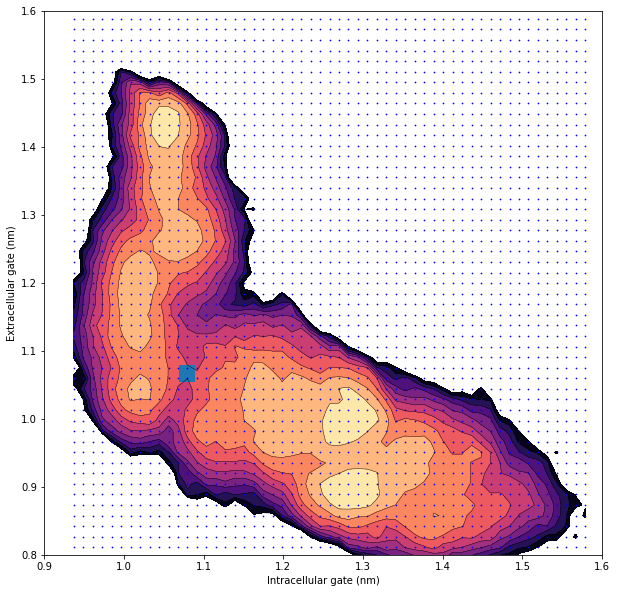

In [30]:
%matplotlib inline

f,ax=plt.subplots(1,1,figsize=(10,10))

plot_FES(f,ax)

ic,ic_margin,ec,ec_margin = wells_borders[state]
x1 = [ic-ic_margin, ic+ic_margin]
y1 = [ec-ec_margin, ec-ec_margin]
y2 = [ec+ec_margin, ec+ec_margin]

ax.fill_between(x1,y1,y2)

## so that you can see where F will be caught        
IC = np.linspace(extent[0],extent[1],55)
EC = np.linspace(extent[2],extent[3],55)
xx,yy = np.meshgrid(IC,EC)
ax.scatter(xx,yy,s = 0.53,c='blue')

plt.show()

### Next, determine which histos you get from this square

In [31]:
def get_histogram_from_gate_values(state, ic, ic_margin, ec, ec_margin):
    '''
    Pretty straightforward, you are just looping through the grid_label_coord_dict as defined above
    Then you find where each border fits your CV space, so:
      find the mean between ic_l and ic_r (should be in the center of the box), and if the center of the box 
       is further left than ic - margin, and further right than ic+margin, then take that grid! 
    '''
    nearest_grid_dict = {}
    grid_list = [] 
    for grid,val in grid_label_coord_dict.items():
        ic_l,ic_r,ec_u,ec_l = val
        if np.mean([ic_l,ic_r]) >= ic - ic_margin and np.mean([ic_l,ic_r]) <= ic + ic_margin:
            if np.mean([ec_u,ec_l]) >= ec - ec_margin and np.mean([ec_u,ec_l]) <= ec + ec_margin:
                grid_list.append(grid)
                nearest_grid_dict[state]=grid_list
    return nearest_grid_dict

In [32]:
ic, ic_margin, ec, ec_margin = wells_borders[state]
get_histogram_from_gate_values(state, ic, ic_margin, ec, ec_margin)

{'occluded': [929, 930]}

You can validate the histos above by checking `'../confout_files/FES_grids_confouts/influx_BFRU_gate_CV/histogram{grid}/selected_grid_on_FES.png`

### Then, get the energies of these histos

In [33]:
def get_F_at_square(IC_leftmost,IC_rightmost,EC_lowermost,EC_uppermost):
    '''
    First you define your F grids as this usual 55x55 space
    
    Then, determine where in the 55x55 grid your IC vals fall in the range of IC_extent
    Same for EC
    The way I designed the grids was to read left to right, bottom to top
    
    
    Then, you will go through each x,y pair and write out what the x,y pair is and get the F at this position
    You save out the x,y coordinates so that you can control that you are taking the right region in the plot below
    '''
    
    IC_extent = np.linspace(extent[0], extent[1], 55)
    EC_extent = np.linspace(extent[2], extent[3], 55)

    F_col = np.where(np.logical_and(IC_extent>=IC_leftmost, IC_extent<=IC_rightmost))[0]
    F_row = np.where(np.logical_and(EC_extent>=EC_lowermost, EC_extent<=EC_uppermost))[0]

    F_values_at_square = []
    F_xy_indices = []
    
    for x_val in F_row:
        for y_val in F_col:
            F_values_at_square.append(F[x_val,y_val])
            F_xy_indices.append([x_val,y_val])
            
      
    return F_values_at_square, F_xy_indices

Again, validate you are correct in space:

[17, 12] 3.9923590518784433  = grid 930
[18, 12] 3.9135252117383637  = grid 984


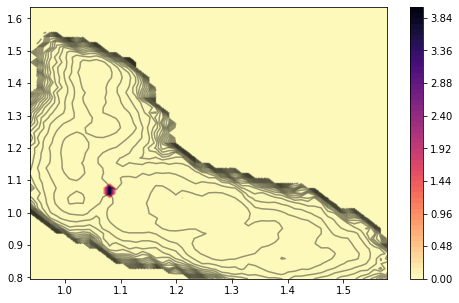

In [34]:
### get the energies, then plot it to confirm


projection_F = np.zeros(np.shape(F))
#projection_F[projection_F == 0] = np.nan

ic, ic_margin, ec, ec_margin = wells_borders[state]
state_energy,state_coords=get_F_at_square(IC_leftmost=ic-ic_margin,
                            IC_rightmost=ic+ic_margin,
                            EC_lowermost=ec-ec_margin,
                            EC_uppermost=ec+ec_margin
                            )

# can also print out which energy is assigned to which grid:
for n, coord in enumerate(state_coords):
    projection_F[coord[0]][coord[1]] = state_energy[n]
    print(coord, state_energy[n], ' = grid',((coord[0]*54)+coord[1]))
    
%matplotlib inline 

f, ax = plt.subplots(figsize = (8,5))

## plot normal FES first
ax.contour(F, extent = extent, colors = 'black', vmin = 0, vmax = 5, levels = 20, alpha = 0.4)

## plot our new projection on top, colored by energies
## note that you make vmax quite low here, so you can easily see contrast
x=ax.contourf(projection_F, extent = extent, vmin = 0, vmax = np.max(state_energy)+0.1, levels = 50, cmap = 'magma_r')
plt.colorbar(x,ax=ax)

# Now to get the confouts of this region!

Choose your grid and then plot where this falls on the IC or EC regions
Then you could play around with which grid you prefer

In [83]:
which_grid=929

In [84]:
indir= f'../confout_files/FES_grids_confouts/{MSM_sim_dir.split("/")[-1]}/histogram_{which_grid}'
cluster_logs=np.loadtxt(f'{indir}/cluster_logs.txt',
                       dtype=str)

In [85]:
max_iter=525

confouts_for_grid=[]

while len(confouts_for_grid) == 0:
    for confout in cluster_logs:
        if int(confout.split('-')[0]) == max_iter:
            confouts_for_grid.append(confout)
    else:
        max_iter=max_iter-1
        
confouts_for_grid = np.array(confouts_for_grid)

In [86]:
confouts_for_grid

array(['525-6-s19.clu452'], dtype='<U16')

IC: 1.077    EC: 1.069


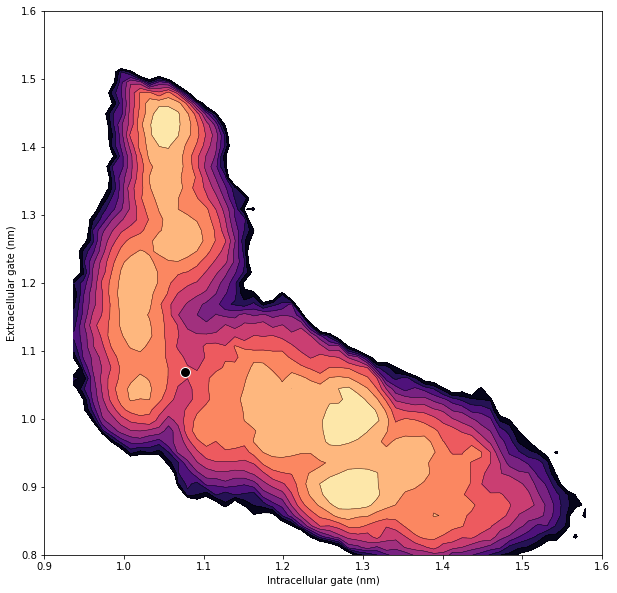

In [79]:
grid_EC_vals = np.loadtxt(f'{indir}/FES_grid_all.EC_gate.xvg')[:,1]
grid_IC_vals = np.loadtxt(f'{indir}/FES_grid_all.IC_gate.xvg')[:,1]


f,ax = plt.subplots(1,1,figsize=(10,10))

plot_FES(f,ax)
for confout in confouts_for_grid:
    cluster_id = int(confout.split('clu')[1])
    print('IC:', grid_IC_vals[cluster_id], '   EC:', grid_EC_vals[cluster_id])
    
    ax.scatter(grid_IC_vals[cluster_id], grid_EC_vals[cluster_id], color='black', edgecolor='white',s=100)
